# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [ ]:
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip
!rm dogImages.zip

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip
!unzip lfw.zip
!rm lfw.zip

In [1]:
import numpy as np
from glob import glob

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


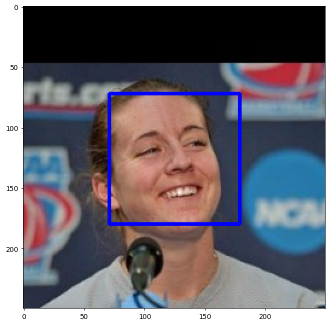

In [2]:
import cv2                
import matplotlib.pyplot as plt      
%matplotlib inline                               

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 50

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [4]:
from tqdm import tqdm

human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.

faces_found_in_dogs = 0
faces_found_in_humans = 0

file_list = tqdm(zip(human_files_short, dog_files_short))
for human_file, dog_file in file_list:
    if face_detector(human_file):
        faces_found_in_humans += 1
    if face_detector(dog_file):
        faces_found_in_dogs += 1

print('Human faces detected in dog files: {}%'.format(faces_found_in_dogs))
print('Human faces detected in human files: {}%'.format(faces_found_in_humans))

100it [00:05, 17.57it/s]

Human faces detected in dog files: 7%
Human faces detected in human files: 99%


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [6]:
import torch
import torchvision.models as models

# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](https://pytorch.org/vision/stable/models.html).

In [7]:
import json
from PIL import Image
import torchvision.transforms as transforms

# Set PIL to be tolerant of image files that are truncated.
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

class_names = None
with open('imagenet1000_clsidx_to_labels.txt', 'r') as f:
    class_names = json.loads(f.read())
    

def Predict(model: torch.nn.Module, img_path: str):
    '''
    Use pre-trained model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        model:    torch model to use and make the prediction
        img_path: path to an image
        
    Returns:
        Index corresponding to model's prediction
    '''
    
    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image

    TX = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((300, 300)),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]),
        ])
        
    X = None
    with Image.open(img_path) as img:
        X = torch.unsqueeze(TX(img), 0)
    
    if use_cuda:
        X = X.cuda()
    
    model.eval()
    Y = model(X)
    predicted = torch.max(Y, 1)[1]

    return predicted # predicted class index

### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [8]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(model: torch.nn.Module, img_path: str):
    ## TODO: Complete the function.    
    idx = Predict(model, img_path)
    return 151 <= idx <= 268  # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [9]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.

def dog_vs_human_eval(model: torch.nn.Module, dogs: list[str], humans: list[str]):
    dogs_found_in_dogs = 0
    dogs_found_in_humans = 0

    files = tqdm(zip(humans, dogs))
    for human_file, dog_file in files:
        if dog_detector(model, human_file):
            dogs_found_in_humans += 1
        if dog_detector(model, dog_file):
            dogs_found_in_dogs += 1

    print('Dogs detected in dog files: {}%'.format(dogs_found_in_dogs))
    print('Dogs detected in human files: {}%'.format(dogs_found_in_humans))

%time dog_vs_human_eval(VGG16, dog_files_short, human_files_short)

0it [00:00, ?it/s]/home/dakkar/.conda/envs/udacity/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448238472/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100it [00:03, 33.09it/s]

Dogs detected in dog files: 100%
Dogs detected in human files: 0%
CPU times: user 35.2 s, sys: 1.07 s, total: 36.2 s
Wall time: 3.02 s


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [10]:
### (Optional) 
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.

MobileNetV3_small = models.mobilenet_v3_small(pretrained=True)

if use_cuda:
    MobileNetV3_small = MobileNetV3_small.cuda()

%time dog_vs_human_eval(MobileNetV3_small, dog_files_short, human_files_short)

100it [00:01, 63.21it/s]

Dogs detected in dog files: 100%
Dogs detected in human files: 0%
CPU times: user 18.4 s, sys: 625 ms, total: 19 s
Wall time: 1.58 s


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [11]:
import os
from torchvision import datasets


### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

class DogDataset(datasets.ImageFolder):
    def __init__(self, root, batch_size=32, size=(512, 512), txs=None, load=False, save=False, overwrite=False):
        super(DogDataset, self).__init__(root)
        np.random.shuffle(self.imgs)
        
        self.txs = transforms.Normalize(
                mean=[0.485, 0.456, 0.406], 
                std=[0.229, 0.224, 0.225]
            ) if txs is None else txs
        
        self.to_tensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize(size),  
        ])

        self.batch_size = batch_size
        self.img_size = size
        self.memory = None
        
        if load:
            self.load()
            if save:
                self.save(overwrite)

    def __len__(self):
        return int(np.ceil(len(self.imgs) / self.batch_size))

    def __getitem__(self, index):
        start = self.batch_size * index
        end = start + self.batch_size
        if start >= len(self.imgs):
            raise StopIteration
        if end > len(self.imgs):
            end = len(self.imgs)

        if self.memory is not None:
            return self.txs(self.memory['x'][start:end]), self.memory['y'][start:end]
        else:
            total = end - start
            batchx = torch.empty((total, 3, *self.img_size))
            batchy = torch.empty((total), dtype=torch.int64)
            for bdx, idx in enumerate(range(start, end)):
                x, y = super(DogDataset, self).__getitem__(idx)
                batchx[bdx, ...] = self.to_tensor(x)
                batchy[bdx] = int(y)
            return batchx, batchy

    def load(self, reload=False, use_disk=True):
        print('Load {} data to memory...'.format(self.root))
        
        if self.memory is not None:
            print('Data already loaded in memory.')
            if not reload:
                return
            print('Reloading...')

        xcache_path = os.path.join(self.root, 'xcache.pt')
        ycache_path = os.path.join(self.root, 'ycache.pt')
        cache_exists = os.path.exists(xcache_path) and os.path.exists(ycache_path)

        if cache_exists and use_disk:
            print('Loading image files using cache files...')
            self.memory = {
                'x': torch.load(xcache_path),
                'y': torch.load(ycache_path)
            }
        else:
            print('Loading image files one by one...')
            total = len(self.imgs)
            self.memory = {
                'x': torch.empty((total, 3, *self.img_size)),
                'y': torch.empty((total), dtype=torch.int64)
            }
            for imgx in tqdm(range(total)):
                x, y = super(DogDataset, self).__getitem__(imgx)
                self.memory['x'][imgx, ...] = self.to_tensor(x)
                self.memory['y'][imgx] = int(y)
    
    def save(self, overwrite=False):
        print('Saving {} cache to disk...'.format(self.root))

        if self.memory is None:
            print('Data not loaded in memory. Call `load` first')
            return

        xcache_path = os.path.join(self.root, 'xcache.pt')
        ycache_path = os.path.join(self.root, 'ycache.pt')
        cache_exists = os.path.exists(xcache_path) and os.path.exists(ycache_path)
        if cache_exists:
            print('Cache already exists.')
            if not overwrite:
                return
            print('Overwrite...')
        torch.save(self.memory['x'], xcache_path)
        torch.save(self.memory['y'], ycache_path)

image_shape=(320, 320)

augmentations = transforms.Compose([
    transforms.ColorJitter(hue=0.1, contrast=0.5, saturation=0.5),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, translate=(.15, .15)),
    transforms.RandomResizedCrop(image_shape, scale=(.75, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

loaders_scratch = {
    'train': DogDataset('dogImages/train', 64, size=image_shape, txs=augmentations, load=True),
    'valid': DogDataset('dogImages/valid', 64, size=image_shape, load=True),
    'test':  DogDataset('dogImages/test' , 64, size=image_shape, load=True),
}

Load dogImages/train data to memory...
Loading image files using cache files...
Load dogImages/valid data to memory...
Loading image files using cache files...
Load dogImages/test data to memory...
Loading image files using cache files...


**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**:

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [12]:
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple

def scale(filters, multiplier=1.0, base=8):
  rounded = int(int(filters) * multiplier / base + 0.5)
  result = int(rounded * base)
  return max(result, base)

class Swish6(nn.Module):
    def __init__(self):
        super(Swish6, self).__init__()
    def forward(self, x):
        return x * F.relu6(x + 3.) * (1. / 6.)

class GlobalAvgPool2d(nn.Module):
    def __init__(self, reshape=False):
        super(GlobalAvgPool2d, self).__init__()
        self.reshape = reshape
    def forward(self, x):
        out = F.avg_pool2d(x, x.shape[2:], stride=1, padding=0)
        return out.reshape(out.shape[:2]) if self.reshape else out

class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
    def forward(self, x):
        return x.reshape(x.shape[0], *self.shape)

class RegularConv2d(nn.Module):
    Params = namedtuple('RegularConv2dParams', 'filters kernel_size stride norm activation', defaults=(3, 1, nn.BatchNorm2d, nn.ReLU6))
    def __init__(self, inputs, filters, kernel_size=3, stride=1, norm=nn.BatchNorm2d, activation=nn.ReLU6):
        super(RegularConv2d, self).__init__()
        layers = [ nn.Conv2d(inputs, filters, kernel_size, stride=stride, padding=kernel_size//2, bias=not norm) ]
        if norm:
            layers.append(norm(filters, eps=1e-3, momentum=0.1))
        layers.append(activation())
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class SqueezeAndExcite(nn.Module):
    def __init__(self, inputs, filters, activation=nn.ReLU6):
        super(SqueezeAndExcite, self).__init__()
        self.net = nn.Sequential(
            GlobalAvgPool2d(),
            RegularConv2d(inputs, filters, 1, norm=None, activation=activation),
            RegularConv2d(filters, inputs, 1, norm=None, activation=nn.Sigmoid)
        )
    def forward(self, x):
        return self.net(x) * x

class DepthwiseConv2d(nn.Module):
    def __init__(self, inputs, filters, kernel_size, stride=1, activation=nn.ReLU6):
        super(DepthwiseConv2d, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(inputs, filters, kernel_size, stride=stride, padding=kernel_size//2, groups=inputs, bias=False),
            nn.BatchNorm2d(filters, eps=1e-3, momentum=0.1),
            activation()
        )
    def forward(self, x):
        return self.net(x)

class Bottleneck(nn.Module):
    Params = namedtuple('BottleneckParams', 'filters kernel_size stride expansion use_residual use_se activation', defaults=(3, 1, 4, True, False, nn.ReLU6))
    def __init__(self, inputs, filters, kernel_size=3, stride=1, expansion=4, use_residual=True, use_se=False, activation=nn.ReLU6):
        super(Bottleneck, self).__init__()
        expand_filters = int(inputs) * expansion
        layers = []
        if expansion > 1:
            layers.append(RegularConv2d(inputs, expand_filters, 1, activation=activation))
        layers.append(DepthwiseConv2d(expand_filters, expand_filters, kernel_size, stride, activation))
        if use_se:
            hidden_dim = scale(expand_filters, 0.25)
            layers.append(SqueezeAndExcite(expand_filters, hidden_dim, activation))
        layers.append(RegularConv2d(expand_filters, filters, 1, activation=nn.Identity))
        self.net = nn.Sequential(*layers)
        self.use_residual = stride == 1 and inputs == filters and use_residual
    def forward(self, x):
        out = self.net(x)
        return out + x if self.use_residual else out

class Fused(nn.Module):
    Params = namedtuple('FusedParams', 'filters kernel_size stride expansion use_residual use_se activation', defaults=(3, 1, 8, True, False, nn.ReLU6))
    def __init__(self, inputs, filters, kernel_size=3, stride=1, expansion=8, use_residual=True, use_se=False, activation=nn.ReLU6):
        super(Fused, self).__init__()
        expand_filters = int(inputs) * expansion
        layers = [ RegularConv2d(inputs, expand_filters, kernel_size, stride, activation=activation) ]
        if use_se:
            hidden_dim = scale(expand_filters, 0.25)
            layers.append(SqueezeAndExcite(expand_filters, hidden_dim, activation))
        layers.append(RegularConv2d(expand_filters, filters, 1, activation=nn.Identity))
        self.net = nn.Sequential(*layers)
        self.use_residual = stride == 1 and inputs == filters and use_residual
    def forward(self, x):
        out = self.net(x)
        return out + x if self.use_residual else out

class Tucker(nn.Module):
    Params = namedtuple('TuckerParams', 'filters kernel_size stride in_ratio out_ratio use_residual activation', defaults=(3, 1, 0.25, 0.25, True, nn.ReLU6))
    def __init__(self, inputs, filters, kernel_size=3, stride=1, in_ratio=0.25, out_ratio=0.25, use_residual=True, activation=nn.ReLU6):
        super(Tucker, self).__init__()
        self.use_residual = stride == 1 and inputs == filters and use_residual
        hidden_in = scale(inputs, in_ratio)
        hidden_out = scale(filters, out_ratio)
        self.net = nn.Sequential(
            RegularConv2d(inputs, hidden_in, 1, activation=activation),
            RegularConv2d(hidden_in, hidden_out, kernel_size, stride, activation=activation),
            RegularConv2d(hidden_out, filters, 1, activation=nn.Identity),
        )
    def forward(self, x):
        out = self.net(x)
        return out + x if self.use_residual else out

LAYERS = {
    'conv': RegularConv2d,
    'fused': Fused,
    'tucker': Tucker,
    'bottleneck': Bottleneck
}

SETTINGS = [
    ('conv'      , RegularConv2d.Params(16, stride=2)),
    ('bottleneck', Bottleneck.Params(8, expansion=1)),
    ('fused'     , Fused.Params(16, stride=2, expansion=4)),
    ('bottleneck', Bottleneck.Params(16)),
    ('tucker'    , Tucker.Params(16, out_ratio=0.75)),
    ('tucker'    , Tucker.Params(16, out_ratio=0.75)),
    ('bottleneck', Bottleneck.Params(32, 5, 2, 8)),
    ('bottleneck', Bottleneck.Params(32)),
    ('tucker'    , Tucker.Params(32, in_ratio=0.75, out_ratio=0.75)),
    ('tucker'    , Tucker.Params(32, in_ratio=0.75, out_ratio=0.75)),
    ('bottleneck', Bottleneck.Params(72, 5, 2, 8)),
    ('bottleneck', Bottleneck.Params(72)),
    ('bottleneck', Bottleneck.Params(72)),
    ('tucker'    , Tucker.Params(72, out_ratio=0.75)),
    ('bottleneck', Bottleneck.Params(96, kernel_size=5, expansion=8)),
    ('bottleneck', Bottleneck.Params(96, expansion=8)),
    ('bottleneck', Bottleneck.Params(96, kernel_size=5, expansion=8)),
    ('bottleneck', Bottleneck.Params(96, kernel_size=5)),
    ('bottleneck', Bottleneck.Params(104, kernel_size=5, stride=2)),
    ('tucker'    , Tucker.Params(104, 3, 1, 0.25, 0.75)),
    ('tucker'    , Tucker.Params(104, 3, 1, 0.75, 0.75)),
    ('tucker'    , Tucker.Params(104, 3, 1, 0.25, 0.75)),
    ('bottleneck', Bottleneck.Params(192, kernel_size=5, expansion=8))
]

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self, n_classes=133, settings=SETTINGS, hidden_top=256, dropout=0.25, use_se=False, depth_multiplier=1.0):
        super(Net, self).__init__()
        ## Define layers of a CNN
        inputs = 3
        layers = []
        for layer, params in settings:
            if layer in ['fused', 'bottleneck']:
                params = params._replace(use_se=use_se)
            params = params._replace(filters=scale(params[0], depth_multiplier), activation=Swish6)
            layers.append(LAYERS[layer](inputs, **params._asdict()))
            inputs = params[0]
        layers.extend([
            GlobalAvgPool2d(True),
            nn.Dropout(dropout),
            nn.Linear(inputs, hidden_top),
            nn.Linear(hidden_top, n_classes)
        ])
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        ## Define forward behavior
        return self.net(x)

#-#-# You do NOT have to modify the code below this line. #-#-#]

# instantiate the CNN
model_scratch = Net(settings=SETTINGS, hidden_top=512, use_se=True, depth_multiplier=1.5)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

from torchsummary import summary
summary(model_scratch, (3, *image_shape))

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [13]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.Adam(model_scratch.parameters(), lr=0.001)
scheduler_scratch = optim.lr_scheduler.ReduceLROnPlateau(optimizer_scratch, patience=5, factor=0.75, min_lr=1e-18)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [14]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def compute_accuracy(outputs, target):
    size = target.shape[0]
    # convert output probabilities to predicted class
    pred = outputs.max(1, keepdim=True)[1]
    # compare predictions to true label
    correct = pred.eq(target.data.view_as(pred)).squeeze().sum().item()
    return correct / size

def train(n_epochs, loaders, model, optimizer, scheduler, criterion, use_cuda, save_path, early_stop):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    epoch_improve = 0
    
    metrics = {
        'epoch': [],
        'lr': [],
        'loss': [],
        'val_loss': [],
        'val_acc': []
    }
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        valid_acc = 0.0
        
        len_train = len(loaders['train'])
        print('Epoch {}/{}'.format(epoch, n_epochs))
        pbar = tqdm(enumerate(loaders['train']), total=len_train, unit='step', ascii=" 123456789=", dynamic_ncols=True, bar_format='{n_fmt}/{total_fmt} [{bar:50}] - {elapsed} {rate_fmt}{postfix} - {desc}')
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (images, labels) in pbar:
            # move to GPU
            if use_cuda:
                images, labels = images.cuda(), labels.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            train_loss = train_loss + (loss.item() - train_loss) / (batch_idx + 1)
            loss.backward()
            optimizer.step()
            if (batch_idx + 1) == len_train:
                ######################    
                # validate the model #
                ######################
                model.eval()
                lr = optimizer.param_groups[0]['lr']
                for val_idx, (images, labels) in enumerate(loaders['valid']):
                    # move to GPU

                    if use_cuda:
                        images, labels = images.cuda(), labels.cuda()
                    
                    with torch.no_grad():
                        outputs = model(images)
                    
                    loss = criterion(outputs, labels)
                    valid_loss = valid_loss + (loss.item() - valid_loss) / (val_idx + 1)

                    accuracy = compute_accuracy(outputs, labels)
                    valid_acc = valid_acc + (accuracy - valid_acc) / (val_idx + 1)
                pbar.set_description_str('loss: {:.6f}, val_loss: {:.6f}, val_acc: {:.6f}, lr: {:.2e}'.format(train_loss, valid_loss, valid_acc, lr))
            else:
                pbar.set_description_str('loss: {:.6f}'.format(train_loss))
        scheduler.step(valid_loss)
        metrics['epoch'].append(epoch)
        metrics['lr'].append(lr)
        metrics['loss'].append(train_loss)
        metrics['val_acc'].append(valid_acc)
        metrics['val_loss'].append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss improved from {:.6f} to {:.6f}. Saving model to {}.'.format(
                valid_loss_min,
                valid_loss,
                save_path
            ))
            epoch_improve = epoch
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
        else:
            print('Validation loss hasn\'t improved since epoch {}.'.format(epoch_improve))
        
        if early_stop == (epoch - epoch_improve):
            print('Stopping training early.')
            break
            
    # return trained model
    return model, metrics

# train the model
model_scratch, metrics = train(50, loaders_scratch, model_scratch, optimizer_scratch, scheduler_scratch, criterion_scratch, use_cuda, 'model_scratch.pt', 10)

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

### Plot training metrics

Following chart shows how the training loss, validation loss and accuracy improved and what was the learning rate at each step.

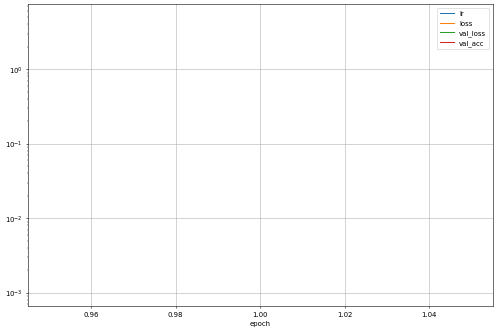

In [15]:
import pandas as pd

df = pd.DataFrame(metrics)
df.set_index(['epoch'], inplace=True)

df.plot()
plt.yscale('log')
plt.legend()
plt.grid()
plt.show()

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [15]:
def test(loaders, model, criterion, use_cuda):
    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + (loss.data - test_loss) / (batch_idx + 1)
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))
    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [16]:
### TODO: Specify data loaders

class RandomGaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2), p=0.5):
        self.prob = p
        self.blur = transforms.GaussianBlur(kernel_size, sigma)
    def __call__(self, x):
        return self.blur(x) if np.random.random() > self.prob else x


augmentations_transfer = transforms.Compose([
    transforms.ColorJitter(contrast=0.5, saturation=0.5),
    transforms.RandomHorizontalFlip(),
    RandomGaussianBlur((3, 3)),
    transforms.RandomAffine((-20, 20), translate=(.15, .15)),
    transforms.RandomResizedCrop(image_shape, scale=(.75, 1)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

loaders_transfer = loaders_scratch
loaders_transfer['train'].txs = augmentations_transfer


### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [17]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = Net(settings=PIXEL1_CPU_SETTINGS, hidden_top=512, use_se=True, dropout=0.1, depth_multiplier=1.5)

if use_cuda:
    model_transfer = model_transfer.cuda()

model_transfer.load_state_dict(torch.load('model_scratch.pt'))

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [20]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.0001)
scheduler_transfer = optim.lr_scheduler.ReduceLROnPlateau(optimizer_transfer, patience=5, min_lr=1e-23)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [18]:
n_epochs = 50
early_stop = 10

# train the model
model_transfer, metrics = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, scheduler_transfer, criterion_transfer, use_cuda, 'model_transfer.pt', early_stop)

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [21]:
test(loaders_scratch, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.338512


Test Accuracy: 62% (523/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [22]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
class_names = [item[4:].replace("_", " ") for item in loaders_transfer['train'].classes]

def predict_breed_transfer(img_path):
    preidction = Predict(model_transfer, img_path)
    return class_names[preidction]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

This is a Chinese shar-pei.


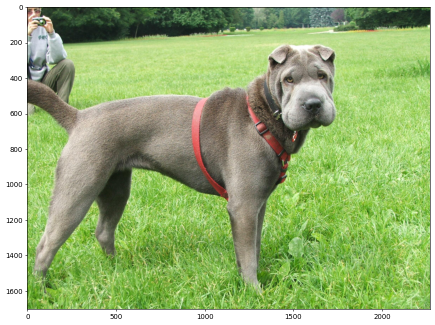

In [47]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

def run_app(img_path):
    ## handle cases for a human face, dog, and neither
    is_face = face_detector(img_path)
    is_dog = dog_detector(MobileNetV3_small, img_path)

    p = Predict(model_transfer, img_path)
    predicted_dogbreed = class_names[p]
    
    dog_pics = [ pic for pic in dog_files if pic.find(predicted_dogbreed.replace(' ', '_')) != -1]
    dog = Image.open(dog_pics[np.random.randint(0, len(dog_pics))])
    img = Image.open(img_path)

    if is_face and not is_dog:
        print('This is a human :)... and looks like a {}'.format(predicted_dogbreed))
        print('Do you see the resemblance?')
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
    elif is_face and is_dog:
        print('Ahmm... I\'m confused, this might be a {} with its owner or a dog that also looks like a human...'.format(predicted_dogbreed))
        print('Here is another picture of the predicted breed.')
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
    elif not is_dog:
        print('Doesn\'t look like a human. Is it a {}?'.format(predicted_dogbreed))
        plt.subplot(121)
        plt.imshow(img)
        plt.subplot(122)
    else:
        print('This is a {}.'.format(predicted_dogbreed))

    plt.imshow(dog)
    plt.show()

run_app(dog_files[121])

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

This is a human :)... and looks like a Labrador retriever
Do you see the resemblance?


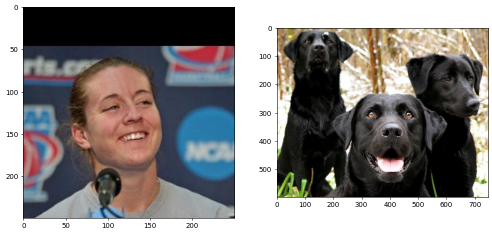

This is a human :)... and looks like a Poodle
Do you see the resemblance?


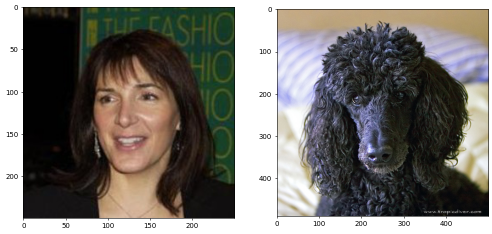

This is a human :)... and looks like a Collie
Do you see the resemblance?


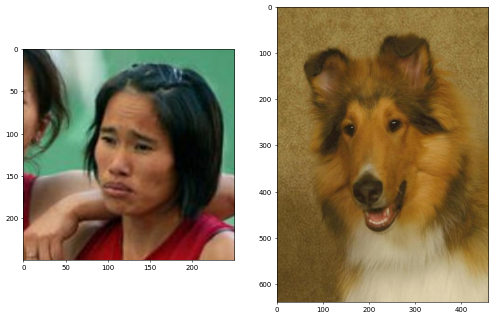

This is a Saint bernard.


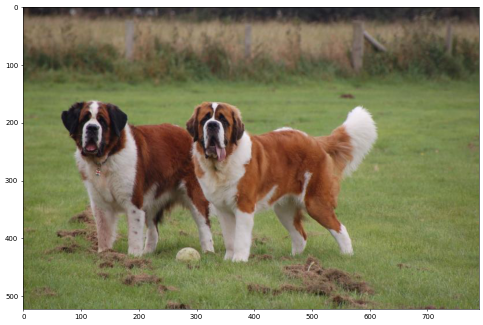

This is a Saint bernard.


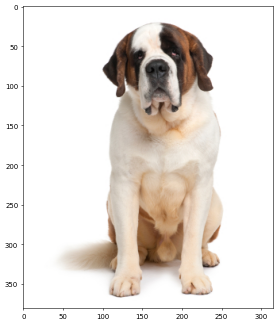

This is a Saint bernard.


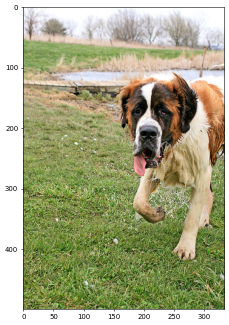

In [48]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)